# In this notebook, we'll make a dataset of syllable spectrograms
If your dataset is in the right format, this notebook shouldn't need any adjustments, beyond hyper parameters. 

After segmenting, we generate a JSON with new syllable segments. 

This might require a few GBs of RAM since we're loading the entire dataset. If your dataset is large or your computer doesn't have much RAM, you might want to break this down into batches, rewrite the code to memmap, etc. Let me know if you have issues here and we can try to figure out a solution.

In [1]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
DATASET_ID = 'koumura_bengalese_finch'

In [3]:
# create a set of hyperparameters for processing this dataset.  
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=15000,
    butter_lowcut = 500,
    butter_highcut = 15000,
    ref_level_db = 20,
    min_level_db = -30,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)

### Create a dataset object
The dataset object loads JSONs corresponding to `DATASET_ID` in the data folder. 

In [4]:
# create a dataset object, which
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.5s


[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2964 out of 2964 | elapsed:    7.5s finished


In [5]:
# to make sure everything loaded correctly, lets look at a sample JSON
print(json.dumps(dataset.sample_json, indent=4, default=str)[:400] + '...')

{
    "species": "Lonchura striata domestica",
    "common_name": "Bengalese finch",
    "wav_loc": "/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/raw/koumura/zip_contents/Bird8/Wave/108.wav",
    "samplerate_hz": 32000,
    "length_s": 8.8725,
    "indvs": {
        "Bird8": {
            "notes": {
                "start_times": [
                    1.158,
                    1.323,
...


In [6]:
# how many wavs are in the dataset?
len(dataset.data_files)

2964

### Create a a pandas dataframe from the dataset
- We use joblib to parallelize the code, but all we're doing is grabbing the note start and stop times from the JSONs

In [7]:
from tqdm.autonotebook import tqdm
from avgn.signalprocessing.create_spectrogram_dataset import (
    prepare_wav,
    create_label_df,
    get_row_audio,
)
import pandas as pd
import numpy as np

In [8]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [9]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=['labels', 'sequence_num'],
            unit="notes",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1878s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 274 ta

[Parallel(n_jobs=-1)]: Done 2964 out of 2964 | elapsed:    8.5s finished


214969

In [10]:
syllable_df[:3]

,start_time,end_time,labels,sequence_num,indv,indvi,key
0,1.158,1.239,0,0,Bird8,0,Bird8_108
1,1.323,1.411,0,0,Bird8,0,Bird8_108
2,1.430,1.533,1,0,Bird8,0,Bird8_108


### For each syllable, grab the corresponding audio
- Here we're looking through the wav files corresponding to the syllable, and grabbing the audio starting at `start_time` and ending at `end_time`

In [11]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0866s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 294 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 436 ta

[Parallel(n_jobs=-1)]: Done 2836 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 2964 out of 2964 | elapsed:   39.6s finished


214969

In [12]:
# this is just getting rid of syllables that are zero seconds long, which be the product of errors in segmentation
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])
syllable_df = syllable_df[np.array(df_mask)]

In [13]:
syllable_df[:3]

,start_time,end_time,labels,sequence_num,indv,indvi,key,audio,rate
0,1.158,1.239,0,0,Bird8,0,Bird8_108,"[-0.00031647197, -0.0003104706, -8.841074e-05,...",32000
1,1.323,1.411,0,0,Bird8,0,Bird8_108,"[8.8008994e-05, 9.9866666e-05, -9.1904745e-05,...",32000
2,1.430,1.533,1,0,Bird8,0,Bird8_108,"[0.000140124, 0.0002206166, -0.00021621873, -0...",32000


### Normalize the audio
- you can skip this step if you don't want to normalize the audio

In [14]:
import librosa

In [15]:
syllable_df['audio'] = [librosa.util.normalize(i) for i in syllable_df.audio.values]

In [16]:
import matplotlib.pyplot as plt

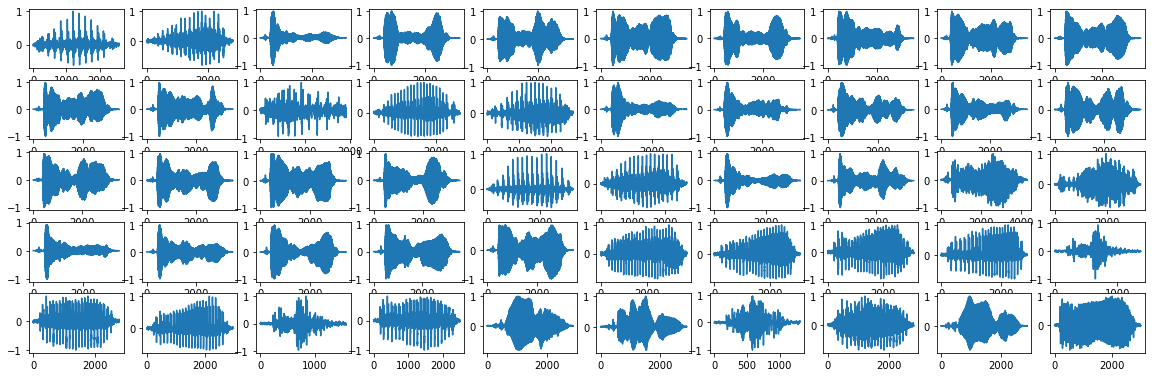

In [17]:
# plot some example audio 
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(syllable_df['audio'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms of each syllable

In [18]:
from avgn.signalprocessing.create_spectrogram_dataset import make_spec

In [19]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllable_df.audio.values, syllable_df.rate.values),
            total=len(syllable_df),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0375s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1034s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1042s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 212672 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 214533 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 214658 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 214785 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 214969 out of 214969 | elapsed:   41.6s finished


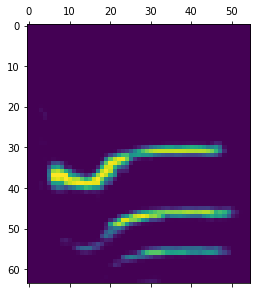

In [20]:
# plot an example syllable
plt.matshow(syllables_spec[10])

### Rescale spectrogram
This is another optional step. It is to log rescale the length of your syllable spectrogram. It is useful when there is a wide distribution of syllable lengths (e.g. 2 seconds and 0.25 seconds). 

In [21]:
from avgn.signalprocessing.create_spectrogram_dataset import log_resize_spec

In [22]:
# hyperparameter, where larger = higher dimensional spectrogram
log_scaling_factor = 10

In [23]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0062s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0618s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0741s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 212096 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 213372 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 213894 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 214428 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 214969 out of 214969 | elapsed:   25.2s finished


In [24]:
from avgn.visualization.spectrogram import draw_spec_set

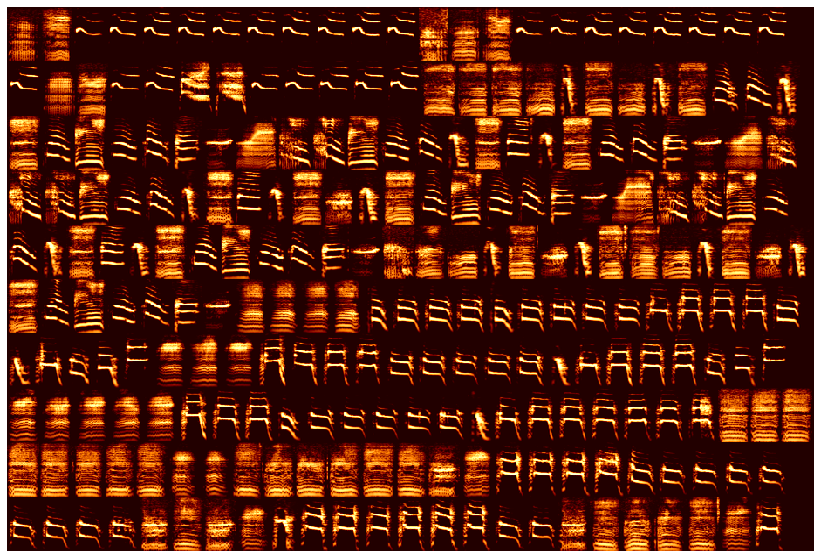

In [25]:
# lets take a look at these spectrograms
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [26]:
# (optional) normalize the spectrograms into uint8, to make the dataset smaller
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]

### Pad spectrograms so each syllable is the same # of dimensions
First, lets look at the distribution of syllable lengths to see how much padding needs to be done. 

In [27]:
# lets look at the 
import seaborn as sns

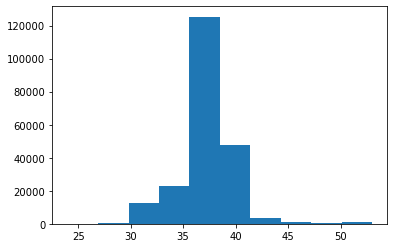

In [28]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
plt.hist(syll_lens);

In [29]:
from avgn.signalprocessing.create_spectrogram_dataset import pad_spectrogram

In [31]:
pad_length = np.max(syll_lens)

In [32]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1746s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0264s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0345s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed: 

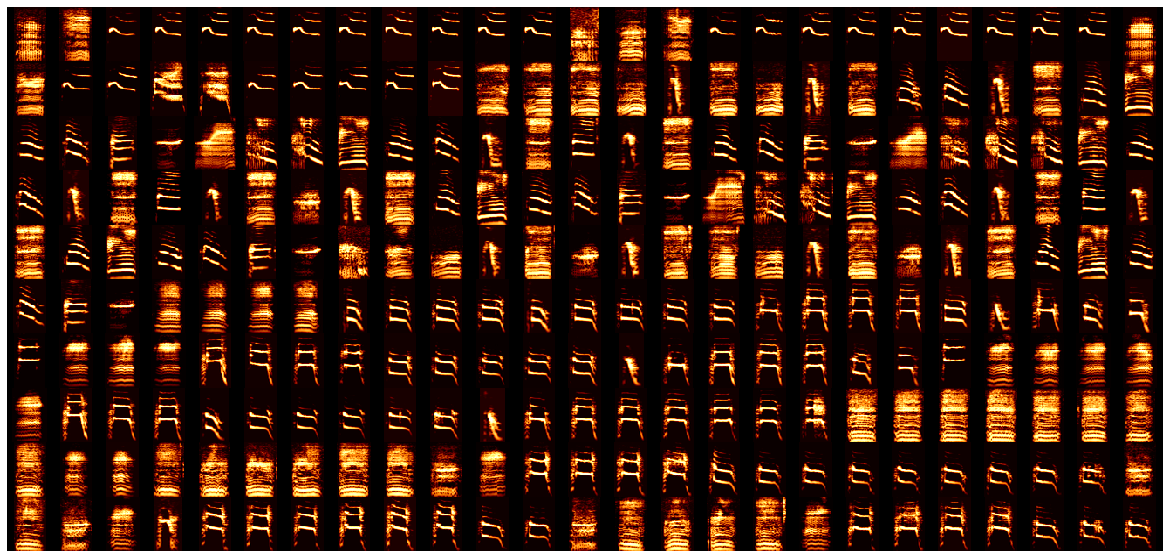

In [33]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [34]:
# what is the dimensionality of the dataset
print(np.shape(syllables_spec))

(214969, 64, 53)


In [35]:
# convert to uint8 to save space
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]

In [36]:
syllable_df['spectrogram'] = syllables_spec

In [37]:
syllable_df[:3]

,start_time,end_time,labels,sequence_num,indv,indvi,key,audio,rate,spectrogram
0,1.158,1.239,0,0,Bird8,0,Bird8_108,"[-0.03449162, -0.033837546, -0.009635704, 0.00...",32000,"[[0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 45, 84, 67, 3..."
1,1.323,1.411,0,0,Bird8,0,Bird8_108,"[0.009580225, 0.010870993, -0.010004297, -0.01...",32000,"[[0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 9, 11, 25, ..."
2,1.430,1.533,1,0,Bird8,0,Bird8_108,"[0.0010962893, 0.0017260398, -0.0016916322, -0...",32000,"[[0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8,..."


### Save the datasset
That's it. Now we can save that dataset of syllables, and use it for whatever downstream analyses we're interested in. 

At this point, it's worth looking at the other notebooks in the repo, and trying out those methods (e.g. UMAP projections, clustering, neural network projections, etc).

In [38]:
from avgn.utils.paths import DATA_DIR, ensure_dir

In [39]:
save_loc = DATA_DIR / 'example_bengalese_finch_dataset.pickle'
ensure_dir(save_loc)
# we'll save without the audio (optional)
syllable_df.drop('audio', 1).to_pickle(save_loc)